# Norton viscoplastic model with a Green yield surface

In this example, we implement and solve a rate-dependent viscoplastic constitutive model that combines a Green-type yield surface with a Norton viscoplastic flow rule.

```{admonition} Objectives
:class: important

The goal of this demo is to illustrate how to:

- Define a custom yield surface in stress space that depends on both hydrostatic and deviatoric stress components.

- Implement a Norton-type overstress law, which governs how the viscoplastic strain rate increases with the level of overstress.

- Integrate the constitutive equations over a time step using implicit local updates, solved automatically with the `optimistix` root-finding engine.

- Evaluate the model response for a batch of load cases and initial states.
```

## Model overview

The Green yield function is defined as:

```{math}
f(\bsig) = \sqrt{A^2\,\sigma_m^2 + \frac{3}{2}\,\bs:\bs}
```

where

- $\sigma_m = \frac{1}{3}\,\tr(\bsig)$ is the mean (hydrostatic) stress, and
- $\bs = \bsig - \sigma_m \boldsymbol{I}$ is the deviatoric stress tensor.
- $A$ is a material parameter describing the eccentricity of the Green ellipse.

The Norton flow law relates the viscoplastic strain rate to the overstress $f(\bsig) - \sigma_y$:

```{math}
\dot{\beps}^\text{vp} =
\left\langle\dfrac{f - \sigma_y}{K}\right\rangle_+^m
```

where $\langle \cdot \rangle_+ = \max\{\cdot, 0\}$ is the positive part, $K$ controls the viscosity and $m$ is the Norton exponent.

In [1]:
import jax
import jax.numpy as jnp

jax.config.update("jax_platform_name", "cpu")

import jaxmat
import jaxmat.materials as jm
from jaxmat.tensors import SymmetricTensor2, dev
from jaxmat.loader import ImposedLoading, global_solve
import equinox as eqx
import optimistix as optx
import matplotlib.pyplot as plt

## Model implementation

The final viscoplastic behavior is represented in `jaxmat` as an `equinox.Module` consisting of several other submodules corresponding to:

- the elastic model (isotropic elasticity here)
- the plastic yield surface
- the viscoplastic flow rule
- the material yield stress (no hardening in this example)

### Internal state

Attached to this behavior, we will also need to define the material internal state. The latter derives from `jaxmat.state.AbstractState` and consists here of the total viscoplastic strain $\bepsvp$[^1]. We define the default factory functions to choose the internal state variable initial value.

[^1]: Since we assume no hardening, we do not need to declare the cumulated plastic strain $p$.

In [2]:
class InternalState(jaxmat.state.AbstractState):
    epsvp: SymmetricTensor2 = eqx.field(default_factory=lambda: SymmetricTensor2())

### Green yield surface

We now first define the Green plastic yield surface as the `GreenYieldSurface` module. It takes a single float parameter `A` describing the ellipsoid eccentricity. The yield surface expression is defined in the `__call__` dunder method. A `normal` method is then defined from the yield surface gradient to compute the (non-unitary) normal vector. Note that we define a `safe_zero` decorator to avoid NaNs when the stress tensor is zero, which may happen upon initialization for instance. To avoid NaNs in `jnp.where` sections in adjoint computations, we use the [double `where` trick](https://docs.jax.dev/en/latest/faq.html#gradients-contain-nan-where-using-where).

In [3]:
def safe_zero(method):
    def wrapper(self, x):
        x_norm = jnp.linalg.norm(x)
        x_safe = SymmetricTensor2(tensor=jnp.where(x_norm > 0, x, x))
        return jnp.where(x_norm > 0, method(self, x_safe), 0.0)

    return wrapper


class GreenYieldSurface(eqx.Module):
    A: float = eqx.field(converter=jnp.asarray)

    @safe_zero
    def __call__(self, sig):
        sig_m = jnp.trace(sig) / 3
        s = dev(sig)
        return jnp.sqrt(self.A**2 * sig_m**2 + 3.0 / 2.0 * jnp.vdot(s, s))

    def normal(self, sig):
        return jax.jacfwd(self.__call__)(sig)

### Viscoplastic flow

Next, the Norton flow is defined similarly as a module with two material parameters `K` and `m`. It takes as input to `__call__` the overstress.

In [4]:
class NortonFlow(eqx.Module):
    K: float = eqx.field(converter=jnp.asarray)
    m: float = eqx.field(converter=jnp.asarray)

    def __call__(self, overstress):
        return jnp.maximum(overstress / self.K, 0) ** self.m

### Implicit integration

Finally, we can now define the `GreenViscoPlasticity` behavior. The latter is a subclass of `SmallStrainBehavior` and requires an elastic model, a yield stress (a float here), a plastic yield surface (of Green type here) and a viscoplastic flow (of Norton type here), in addition to its internal state.

The constitutive update is then implemented by first gathering the previous values for the stress and internal state variables. An `eval_stress` method is defined as follows:

```{math}
\bsig =\bsig_n + \CC:(\Delta\beps - \Delta\bepsvp)
```

Finally, the `solve_state` function implemented below computes the new viscoplastic strain $\bepsvp$ as a function of the old value $\bepsvp_n$ and the strain increment $\Delta \beps$ by solving the implicit discretized system of evolution equations:

```{math}
\Delta\bepsvp - \bn \Delta p = \Delta\bepsvp - \dfrac{\partial f}{\partial \bsig}(\bsig) \Delta t \left\langle\dfrac{f(\bsig) - \sigma_y}{K}\right\rangle_+^m = 0
```

where $\bn = \partial f /\partial\bsig$ is the yield surface normal evaluated at the final stress.

The full implementation reads:

In [5]:
class GreenViscoPlasticity(jm.SmallStrainBehavior):
    elastic_model: jm.LinearElasticIsotropic
    yield_stress: float = eqx.field(converter=jnp.asarray)
    plastic_surface: GreenYieldSurface
    viscoplastic_flow: NortonFlow
    internal: InternalState = eqx.field(default_factory=InternalState, init=False)

    @eqx.filter_jit
    @eqx.debug.assert_max_traces(max_traces=1)
    def constitutive_update(self, eps, state, dt):
        eps_old = state.strain
        deps = eps - eps_old
        isv_old = state.internal
        epsvp_old = isv_old.epsvp
        sig_old = state.stress

        def eval_stress(deps, depsvp):
            return sig_old + self.elastic_model.C @ (deps - depsvp)

        def solve_state(deps, epsvp_old):

            def residual(depsvp, args):
                sig = eval_stress(deps, depsvp)
                overstress = self.plastic_surface(sig) - self.yield_stress
                dp = dt * self.viscoplastic_flow(overstress)
                n = self.plastic_surface.normal(sig)
                res = depsvp - n * dp
                epsvp = epsvp_old + depsvp
                return (res, epsvp)

            sol = optx.root_find(
                residual, self.solver, epsvp_old, has_aux=True, adjoint=self.adjoint
            )
            depsvp = sol.value
            epsvp = sol.aux
            sig = eval_stress(deps, depsvp)
            return sig, epsvp

        sig, epsvp = solve_state(deps, epsvp_old)
        isv = isv_old.update(epsvp=epsvp)
        new_state = state.update(strain=eps, stress=sig, internal=isv)
        return sig, new_state

Note that the `residual` function returns the above residual as well as the new viscoplastic strain as an auxiliary argument. We then solve an `optimistix` root-finding problem with a default Newton solver (`self.solver`). In `optimistix`, an adjoint method is also defined in order to compute gradients through the root-finding solver. By default, we use an implicit ajoint solver which back-propagates gradient using the Implicit Function Theorem, [see the `optimistix` docs section](https://docs.kidger.site/optimistix/api/adjoints/#optimistix.ImplicitAdjoint) for more details.

Finally, after solving, we recover the final stress and viscoplastic strain and update the state and internal state variables accordingly.

## Evaluating the model

We now instantiate the Green viscoplastic model from its different components

In [6]:
elastic_model = jm.LinearElasticIsotropic(E=210e3, nu=0.3)
sig0 = 300.0
green_ys = GreenYieldSurface(A=0.6)
viscoplastic_flow = NortonFlow(K=50.0, m=4.0)
material = GreenViscoPlasticity(
    elastic_model=elastic_model,
    yield_stress=sig0,
    plastic_surface=green_ys,
    viscoplastic_flow=viscoplastic_flow,
)

Below, we evaluate the Green yield surface and its normal in the $(p, q)$ space of hydrostatic and deviatoric stresses.

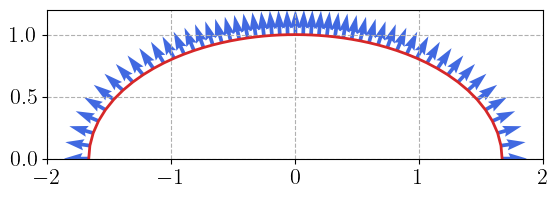

In [7]:
def compute_pq(sig):
    p = jnp.trace(sig) / 3
    s = dev(sig)
    q = jnp.sqrt(3.0 / 2.0 * jnp.vdot(s, s))
    return p, q


def compute_surface_normals(p, q):
    sig = SymmetricTensor2(
        tensor=jnp.diag(jnp.asarray([p + 2 * q / 3, p - q / 3, p - q / 3]))
    )
    ys = green_ys(sig)
    n = green_ys.normal(sig)
    x, y = p / ys, q / ys
    np = jnp.trace(n)
    nq = 2 / 3 * jnp.linalg.norm(dev(n))
    norm_ = jnp.sqrt(np**2 + nq**2)
    return x, y, np / norm_, nq / norm_


angle = jnp.linspace(0, jnp.pi, 51)
p = jnp.cos(angle)
q = jnp.sin(angle)
x, y, np, nq = jax.vmap(compute_surface_normals)(p, q)

plt.plot(x, y, "-C3")
plt.quiver(
    x,
    y,
    np,
    nq,
    units="xy",
    scale_units="xy",
    angles="xy",
    scale=5.0,
    color="royalblue",
)
plt.xlim(-2.0, 2.0)
plt.ylim(0.0, 1.2)
plt.gca().set_aspect("equal")
plt.show()

## Time-dependent load-cases

We now consider a set of time-varying load cases.

### Initial state

We start with an initial hydrostatic stress state $\bsig_{n=0} = - p_0\bI$ for different values of the initial pressure $p_0$. All 8 values for the pressure will form a batch of load cases which will be evaluated simultaneously. We thus start with a default initial state with `material.init_state` with a batch dimension `Nbatch=9`. Then, we modify, in the `state` PyTree, the `stress` field with the imposed initial hydrostatic stresses.

In [8]:
Nbatch = 9
press_vals = jnp.linspace(-sig0, sig0, Nbatch)
state = material.init_state(Nbatch)


def set_initial_press(state, press):
    state = state.update(stress=SymmetricTensor2(tensor=-press * jnp.eye(3)))
    return state


initial_state = eqx.filter_vmap(set_initial_press)(state, press_vals)
print(initial_state.stress[:, 0, 0])

[ 300.  225.  150.   75.   -0.  -75. -150. -225. -300.]


From this initial state, we consider a time-varying imposed strain of a purely deviatoric form $\beps(t) = \epsilon(t)\diag(1,-1/2,-1/2)$ where the loading is first applied linearly with time at a strain rate $\dot\epsilon$ and is then held fixed once reaching the final strain $\epsilon_\text{max} = 2.10^{-3}$, i.e. $\epsilon(t) = \min\{\dot\epsilon t ; \epsilon_\text{max}\}$.

The strain is imposed via the `ImposedLoading` class and the `global_solve` function[^2]. We then recover the stress state in the $(p, q)$ space.

Finally, the stress path is plotted for all imposed initial pressures. The reference yield surface is shown in black and we can observe the plastic evolution for a stress state larger than the elastic yield surface due to the viscous overstress, with a clear effect of the strain rate.

[^2]: Note that, here, it would also have been possible to impose the total strain `Eps` since the load-case is purely strain-driven.

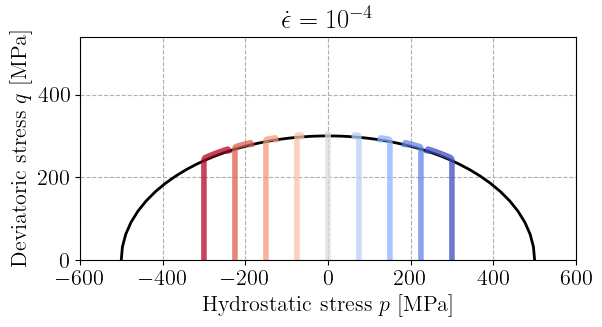

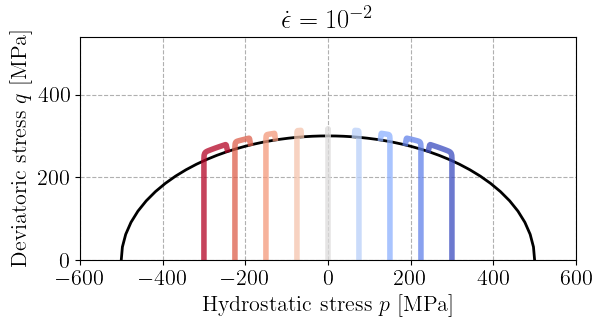

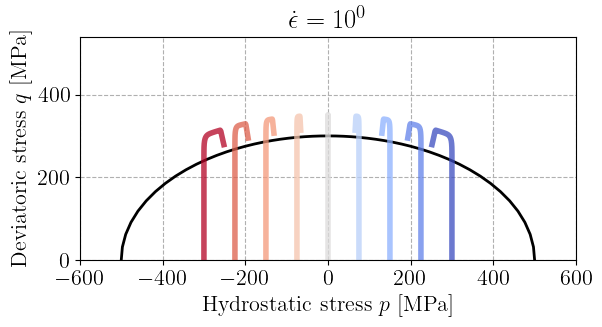

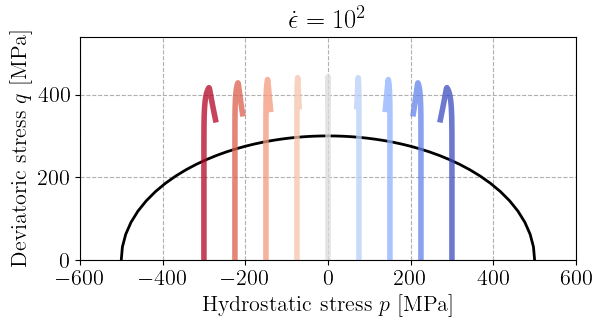

In [9]:
for eps_dot in [1e-4, 1e-2, 1e0, 1e2]:
    eps_max = 2e-3
    Nsteps = 100
    times = jnp.linspace(0, 2 * eps_max / eps_dot, Nsteps)

    t = 0
    imposed_eps = jnp.zeros_like(press_vals)
    results = jnp.zeros((Nsteps, Nbatch, 2))

    state = initial_state
    p, q = jax.vmap(compute_pq)(state.stress)
    results = results.at[0, :, 0].set(p)
    results = results.at[0, :, 1].set(q)
    for i, dt in enumerate(jnp.diff(times)):
        t += dt
        imposed_eps += eps_dot * dt
        imposed_eps = jnp.minimum(imposed_eps, eps_max)

        loading = ImposedLoading(
            epsxx=imposed_eps, epsyy=-imposed_eps / 2, epszz=-imposed_eps / 2
        )

        Eps = state.strain
        Eps, state, stats = global_solve(Eps, state, loading, material, dt)

        Sig = state.stress

        p, q = jax.vmap(compute_pq)(Sig)
        results = results.at[i + 1, :, 0].set(p)
        results = results.at[i + 1, :, 1].set(q)

    cmap = plt.get_cmap("coolwarm")
    colors = cmap(jnp.linspace(0, 1, Nbatch))
    plt.title(rf"$\dot\epsilon=10^{{{jnp.log10(eps_dot):.0f}}}$")
    plt.plot(sig0 * x, sig0 * y, "-k")
    for i in range(Nbatch):
        plt.plot(
            results[:, i, 0],
            results[:, i, 1],
            "-",
            color=colors[i],
            linewidth=4,
            alpha=0.75,
        )
    plt.gca().set_aspect("equal")
    plt.xlim(-2.0 * sig0, 2.0 * sig0)
    plt.ylim(0.0, 1.8 * sig0)
    plt.xlabel("Hydrostatic stress $p$ [MPa]")
    plt.ylabel("Deviatoric stress $q$ [MPa]")
    plt.show()